In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flowToColor
import cv2
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import convolve2d
import scipy
import PIL
from skimage.feature import peak_local_max
import os

You can open GIF files by Safari or Chrome. Answers include: sphere.gif, sphere_pyramid.gif, synth.gif, synth_pyramid.gif, corridor.gif, corridor_pyramid.gif, hotel_out.gif

# 1 Optical flow estimation

## 1.

In [2]:
def myFlow(image1_, image2_, window_length, tau):
    # Spatial Derivative Filter
    derivative_kernel = np.array([[-1, 8, 0, -8, 1]], dtype=np.float64) / 12
    # convolve2d flips the kernel, so there is no need to flip it
    # Computing the Spatial Derivatives
    x_derivative = convolve2d(image1_, derivative_kernel, 'same')
    y_derivative = convolve2d(image1_, derivative_kernel.T, 'same')
    # Smooth the Images for Temporal Derivative
    smooth_image1 = scipy.ndimage.gaussian_filter(image1_, 1.0, truncate=3)
    smooth_image2 = scipy.ndimage.gaussian_filter(image2_, 1.0, truncate=3)
    # Temporal Derivative
    t_derivative = smooth_image2 - smooth_image1
    # Computing the Sum of Derivative Products
    Ixt = scipy.ndimage.uniform_filter(x_derivative * t_derivative, size=window_length)
    Iyt = scipy.ndimage.uniform_filter(y_derivative * t_derivative, size=window_length)
    Ixx = scipy.ndimage.uniform_filter(x_derivative * x_derivative, size=window_length)
    Iyy = scipy.ndimage.uniform_filter(y_derivative * y_derivative, size=window_length)
    Ixy = scipy.ndimage.uniform_filter(x_derivative * y_derivative, size=window_length)
    
    # Ixt = scipy.ndimage.gaussian_filter(x_derivative * t_derivative, 1.0, radius=window_length)
    # Iyt = scipy.ndimage.gaussian_filter(y_derivative * t_derivative, 1.0, radius=window_length)
    # Ixx = scipy.ndimage.gaussian_filter(x_derivative * x_derivative, 1.0, radius=window_length)
    # Iyy = scipy.ndimage.gaussian_filter(y_derivative * y_derivative, 1.0, radius=window_length)
    # Ixy = scipy.ndimage.gaussian_filter(x_derivative * y_derivative, 1.0, radius=window_length)
    
    
    # u_: flow in x direction
    # v_: flow in y direction
    u_ = np.zeros_like(image1_)
    v_ = np.zeros_like(image1_)
    # validity map of flow
    valid_flow_ = np.zeros_like(image1_).astype(np.bool_)
    
    for i in range(u_.shape[0]):
        for j in range(u_.shape[1]):
            
            # Defining the matrix A for each pixel as defined in the assignment document
            A = np.array([[Ixx[i, j], Ixy[i, j]],
                          [Ixy[i, j], Iyy[i, j]]])
            # Defining the vector b for each pixel as defined in the assignment document
            b = np.array([[-Ixt[i, j]], [-Iyt[i, j]]])
            # Compute the eigenvalues of A
            l = np.linalg.eigvals(A).real
            # Check the validity of flow by comparing eigenvalues with the threshold tau
            if l[0] > tau and l[1] > tau:
                # pseudo inverse A and multiply by b
                uv = np.linalg.pinv(A) @ b
                # separate the flow
                uv = uv.flatten()
                u_[i, j] = uv[0]
                v_[i, j] = uv[1]
                valid_flow_[i, j] = True
    
    return u_, v_, valid_flow_

In [3]:
image_sphere1 = cv2.imread('Sequences/sphere/sphere_0.png')
image_sphere1 = cv2.cvtColor(image_sphere1, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
# image1 = cv2.resize(image1, (0, 0), fx = 0.5, fy = 0.5)
image_sphere2 = cv2.imread('Sequences/sphere/sphere_1.png')
image_sphere2 = cv2.cvtColor(image_sphere2, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
# image2 = cv2.resize(image2, (0, 0), fx = 0.5, fy = 0.5)

In [4]:
def ans_helper(image1_, image2_, window_size_list=None, tau_list=None):
    
    if tau_list is None:
        tau_list = [1e-4, 1e-5, 1e-7]
    if window_size_list is None:
        window_size_list = [7, 15, 19]
        
    fig_, ax_ = plt.subplots(len(window_size_list), len(tau_list), figsize=(20, 20))
    fig2, ax2 = plt.subplots(len(window_size_list), len(tau_list), figsize=(20, 20))
    
    for i, w in enumerate(window_size_list):
        for j, tau in enumerate(tau_list):
            u_, v_, valid_flow_ = myFlow(image1_, image2_, w, tau)
            flow = np.array([u_, v_]).transpose((1, 2, 0))
            flow_image = flowToColor.flowToColor(flow)
            ax_[i, j].imshow(flow_image)
            ax_[i, j].set_title(f"window length={w}, threshold={tau}")
            ax2[i, j].imshow(valid_flow_*255, 'gray')
            ax2[i, j].set_title(f"window length={w}, threshold={tau}")
    fig_.suptitle("Flow")
    fig2.suptitle("Valid Flow")
    plt.show()

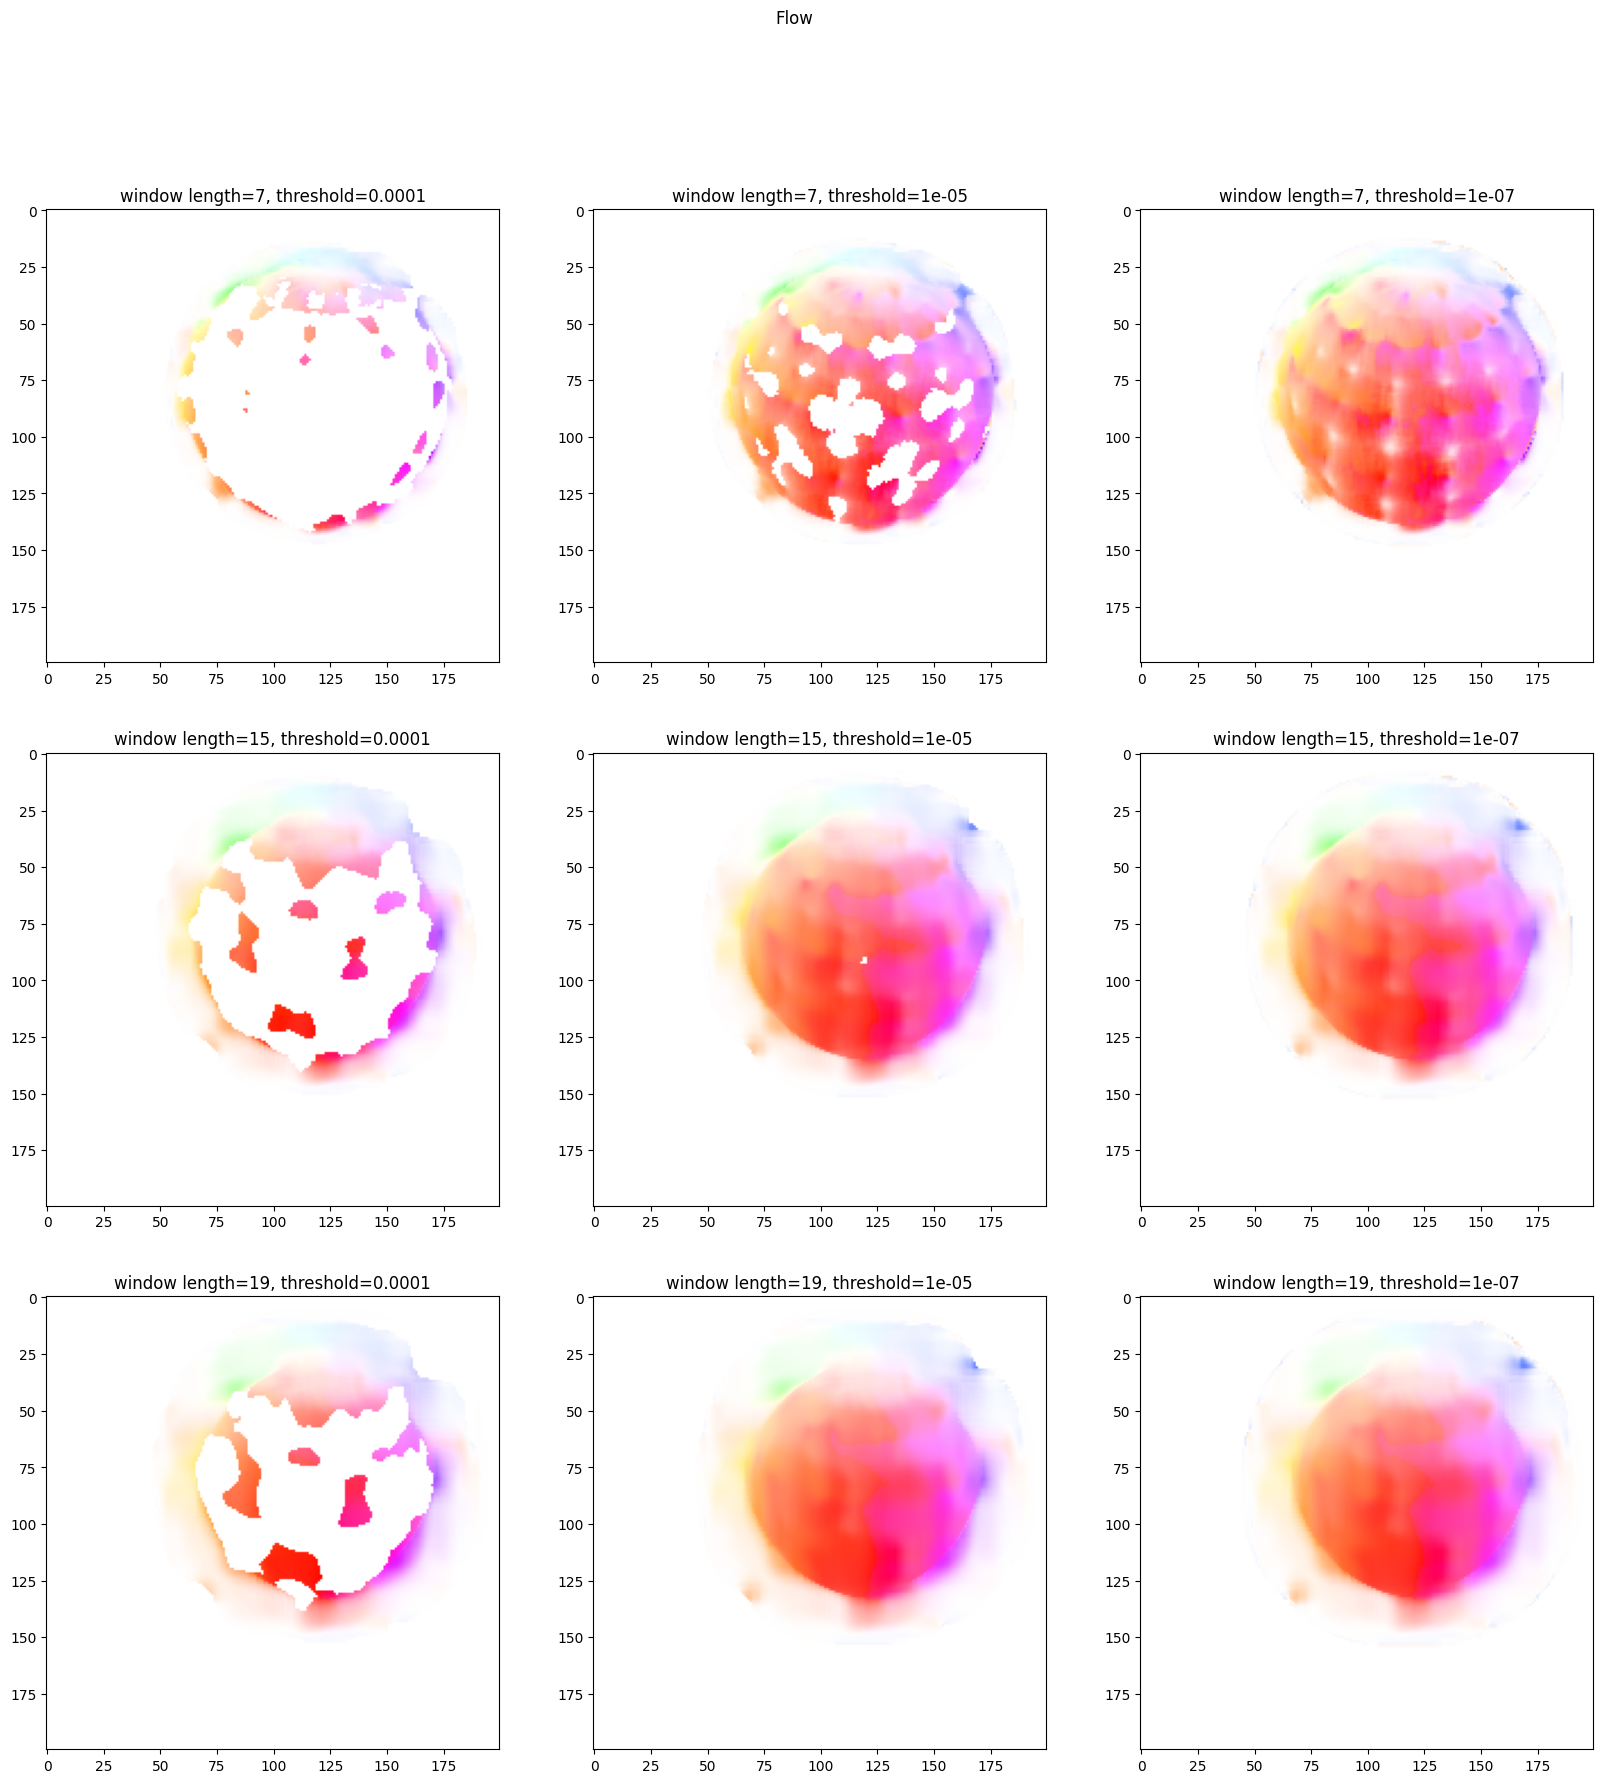

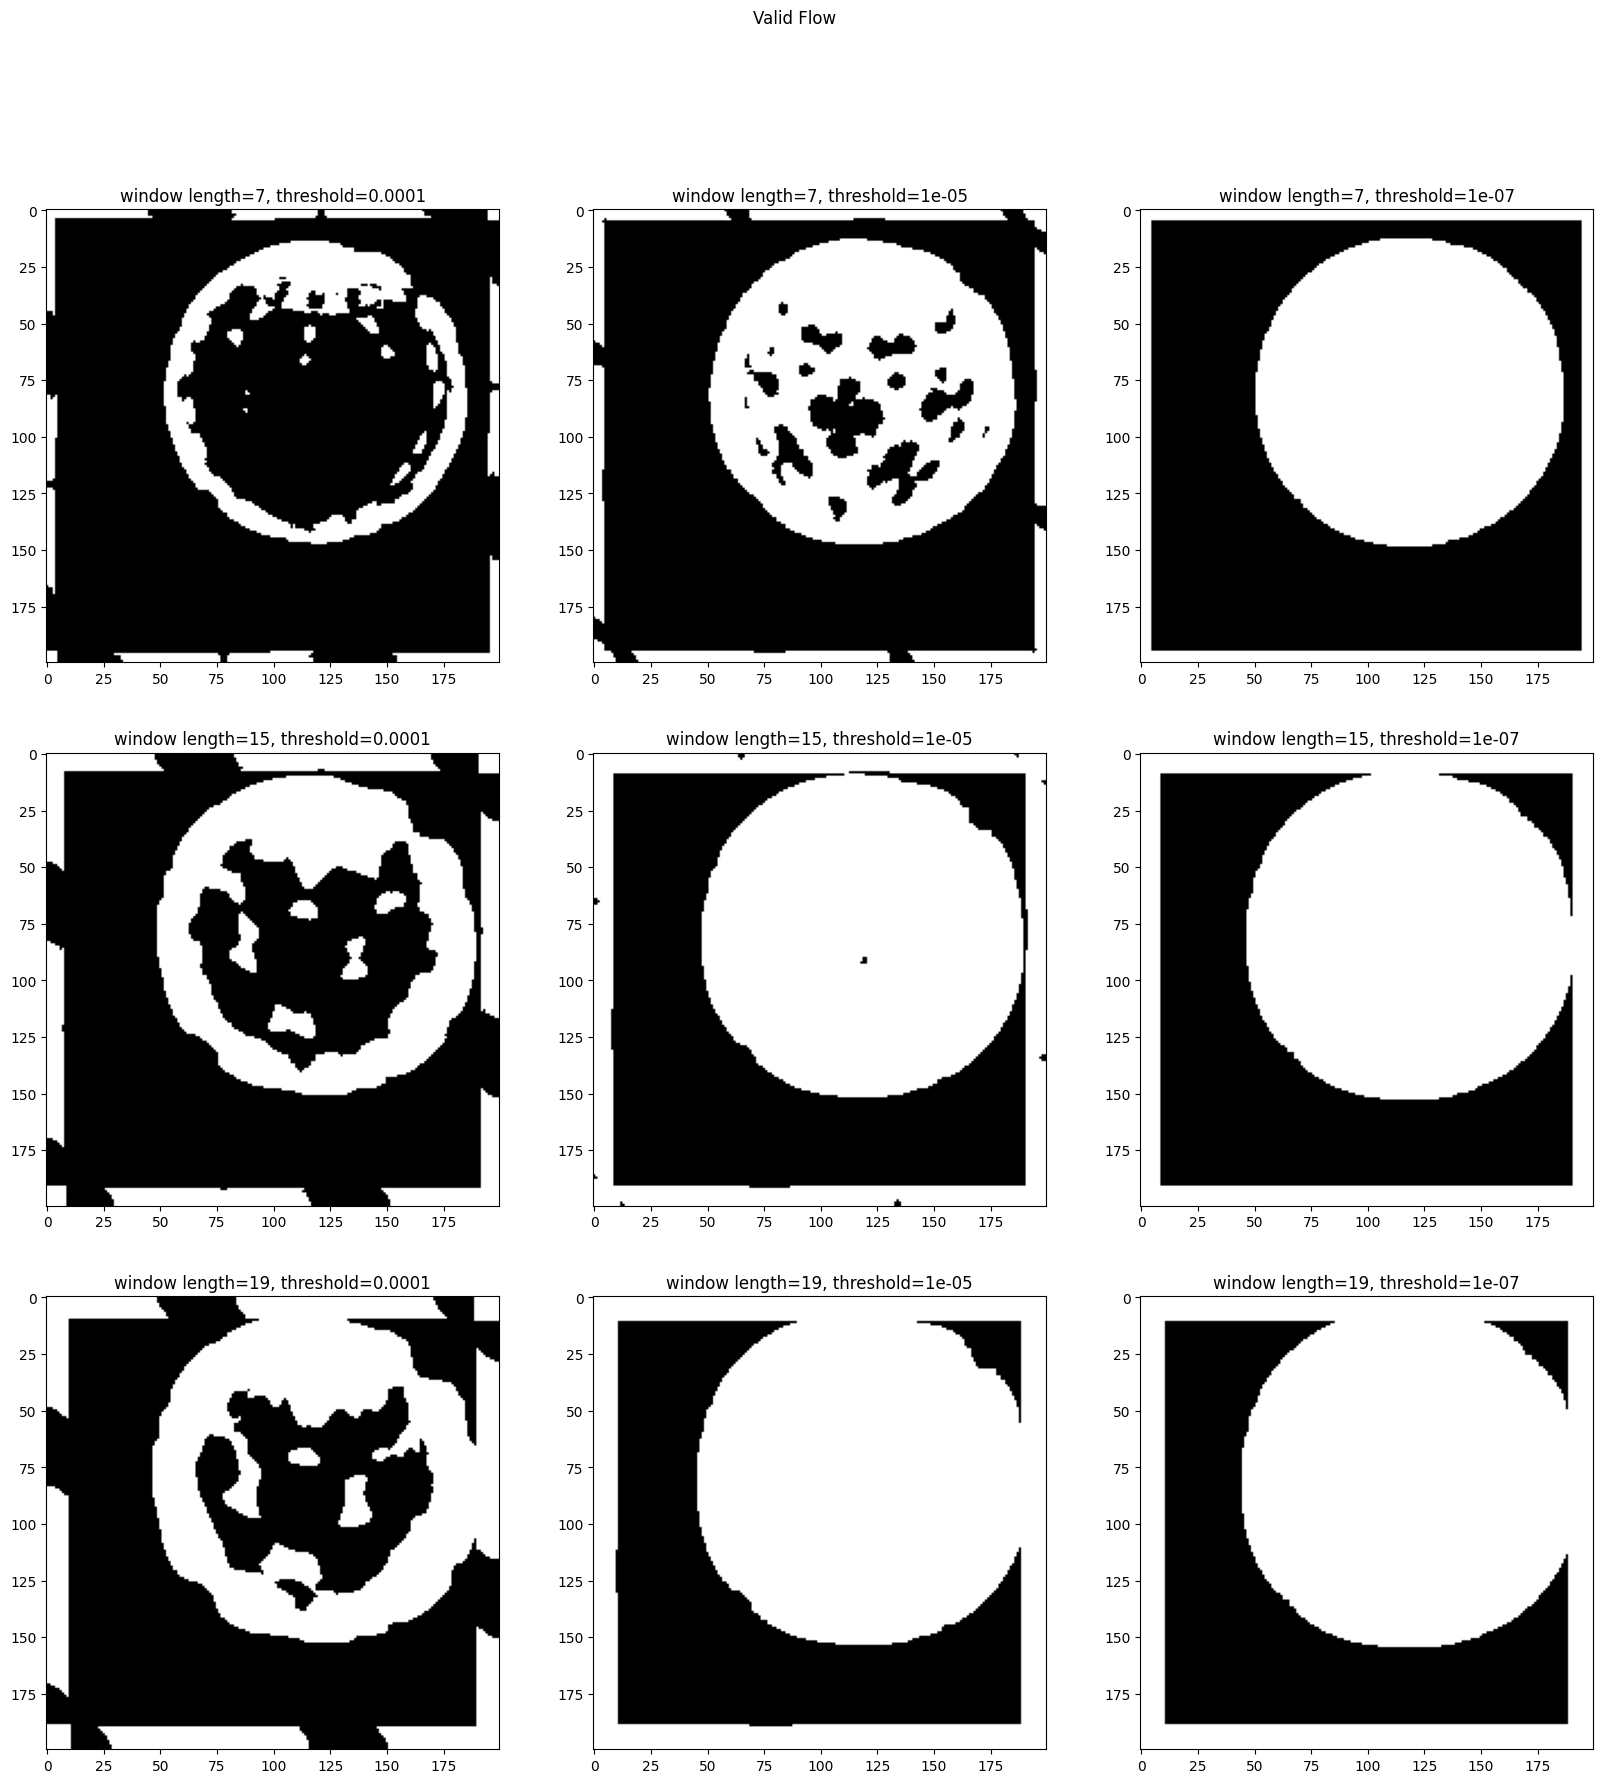

In [5]:
ans_helper(image_sphere1, image_sphere2, window_size_list=[7, 15, 19], tau_list=[1e-4, 1e-5, 1e-7])

In [6]:
image_synth1 = cv2.imread('Sequences/synth/synth_0.png')
image_synth1 = cv2.cvtColor(image_synth1, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
# image1 = cv2.resize(image1, (0, 0), fx = 0.5, fy = 0.5)
image_synth2 = cv2.imread('Sequences/synth/synth_1.png')
image_synth2 = cv2.cvtColor(image_synth2, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
# image2 = cv2.resize(image2, (0, 0), fx = 0.5, fy = 0.5)

In [7]:
###################################################################
###################################################################
###################################################################
# 
# Note: The valid map for the next image is all black because all the values are True and somehow matplotlib inverts it!!
#
###################################################################
###################################################################
###################################################################
###################################################################

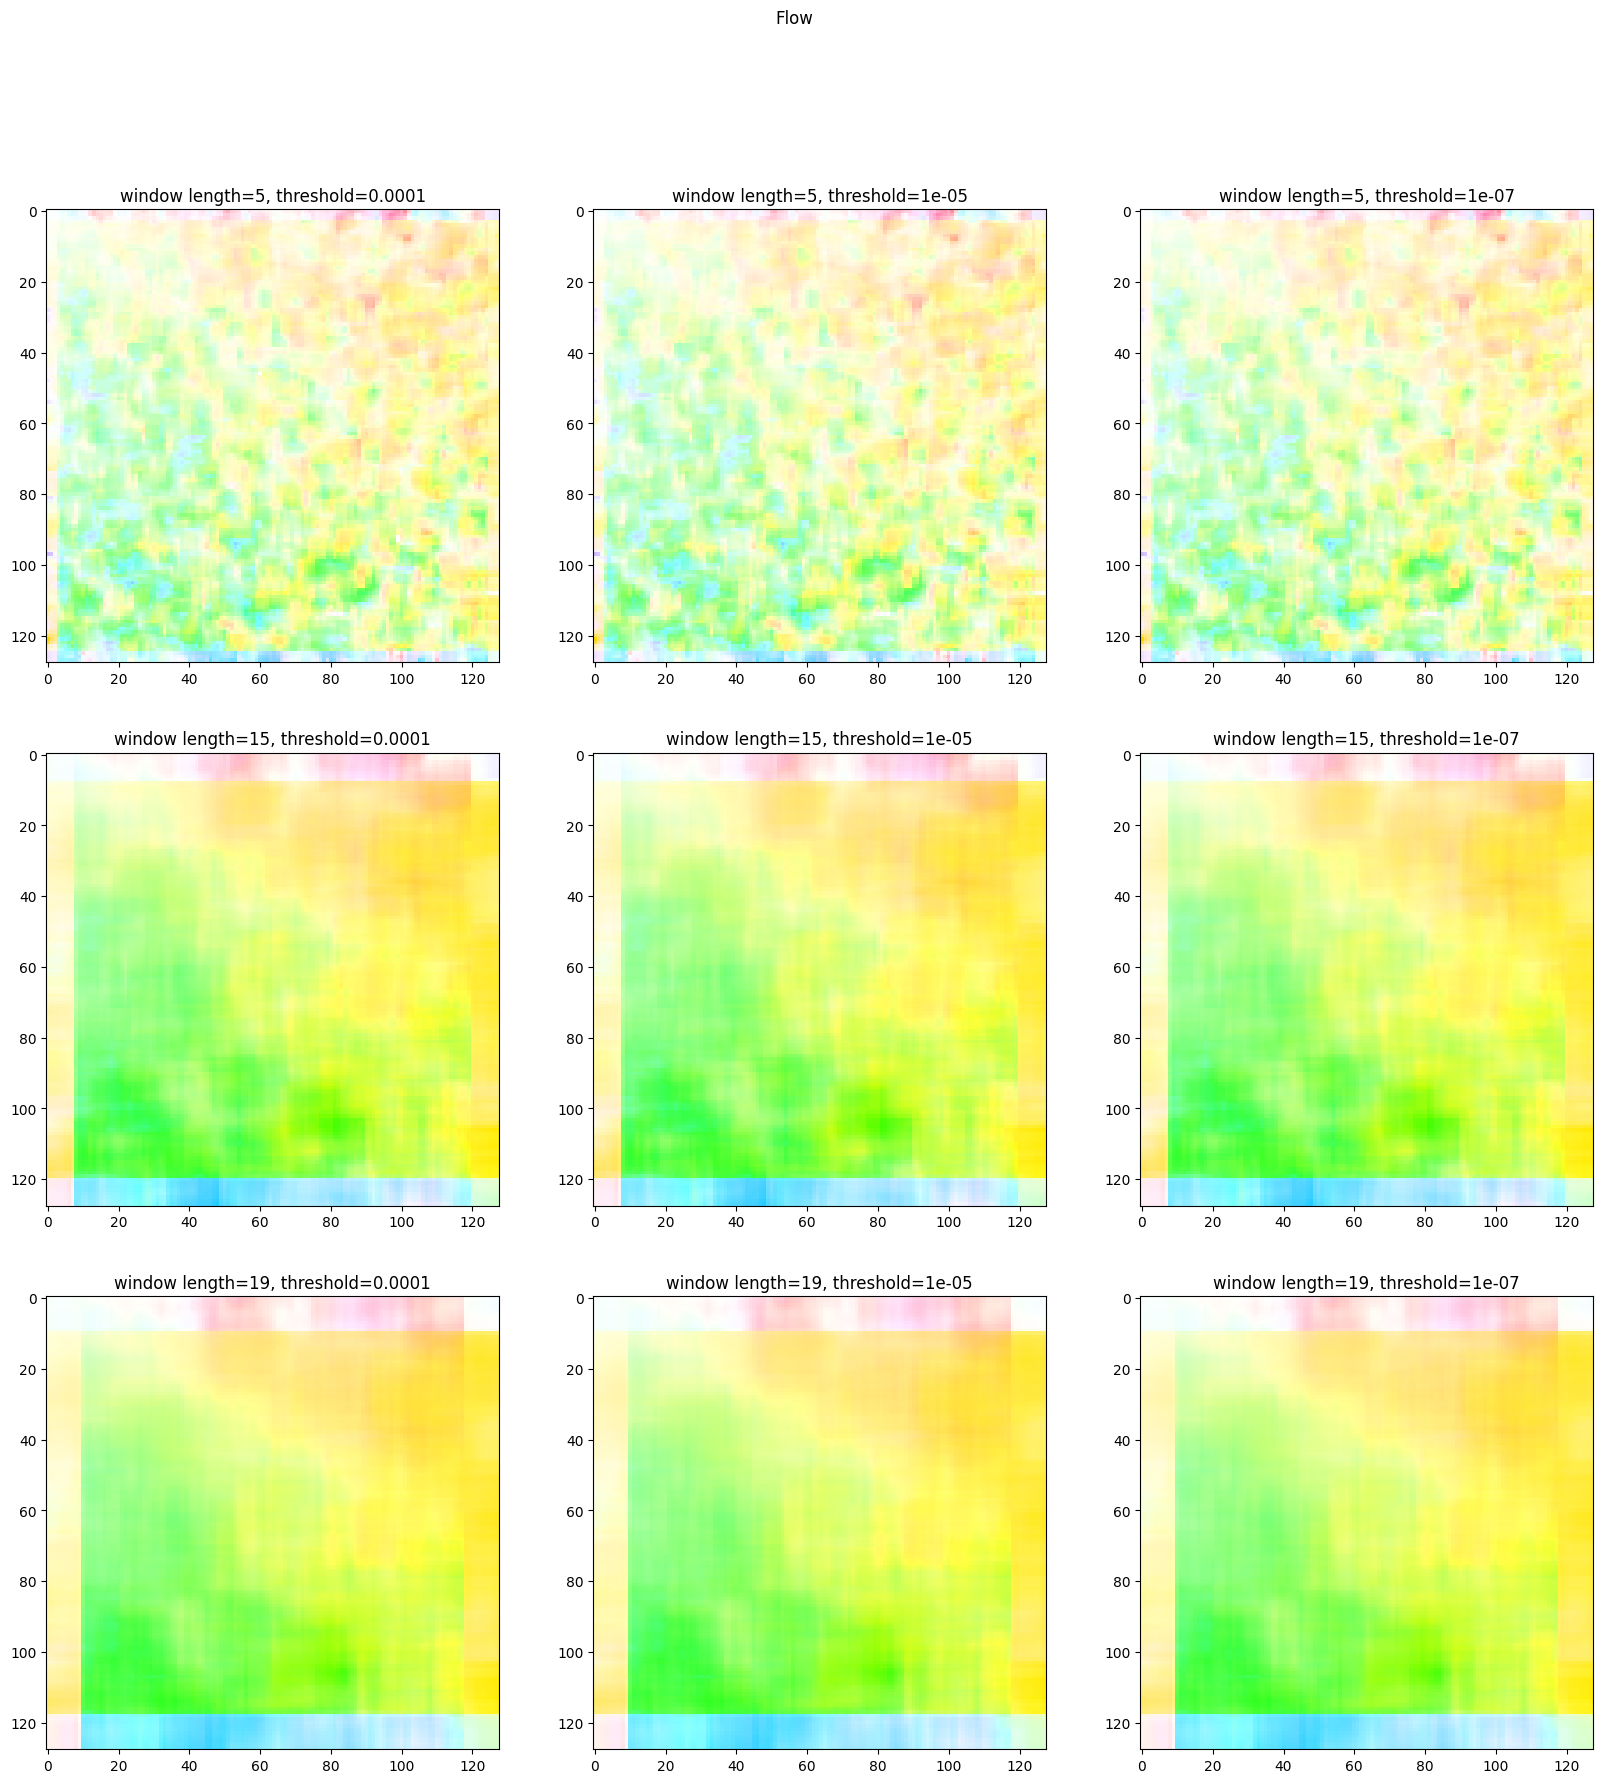

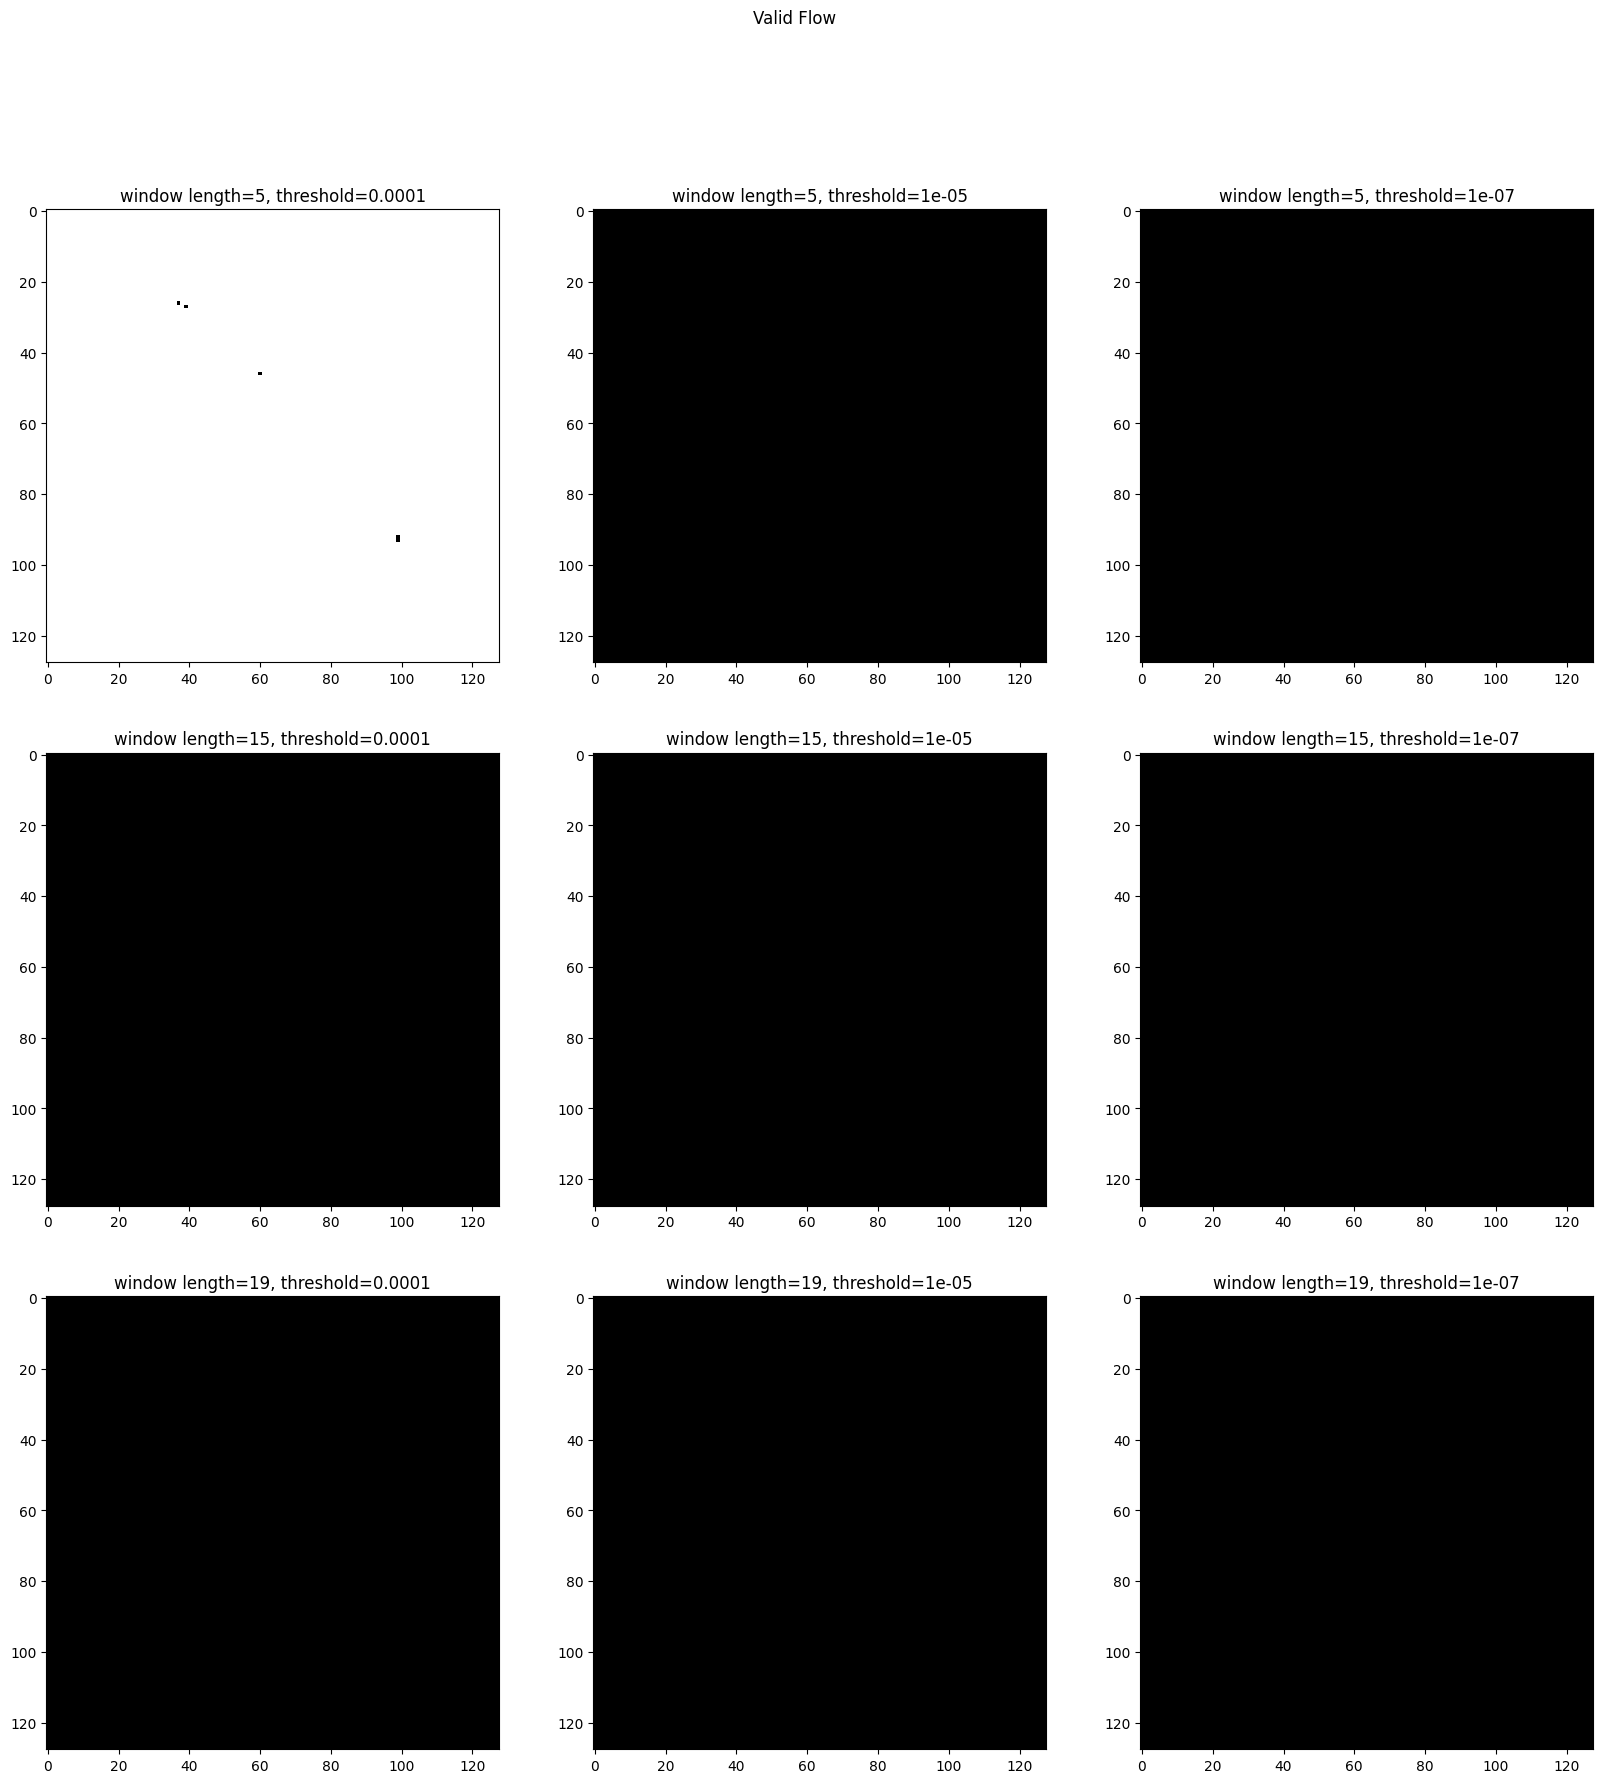

In [8]:
ans_helper(image_synth1, image_synth2, window_size_list=[5, 15, 19], tau_list=[1e-4, 1e-5, 1e-7])

In [9]:
image_corridor1 = cv2.imread('Sequences/corridor/bt_0.png')
image_corridor1 = cv2.cvtColor(image_corridor1, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
# image_corridor1 = cv2.resize(image_corridor1, (0, 0), fx=0.5, fy=0.5)
image_corridor2 = cv2.imread('Sequences/corridor/bt_1.png')
image_corridor2 = cv2.cvtColor(image_corridor2, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
# image_corridor2 = cv2.resize(image_corridor2, (0, 0), fx=0.5, fy=0.5)

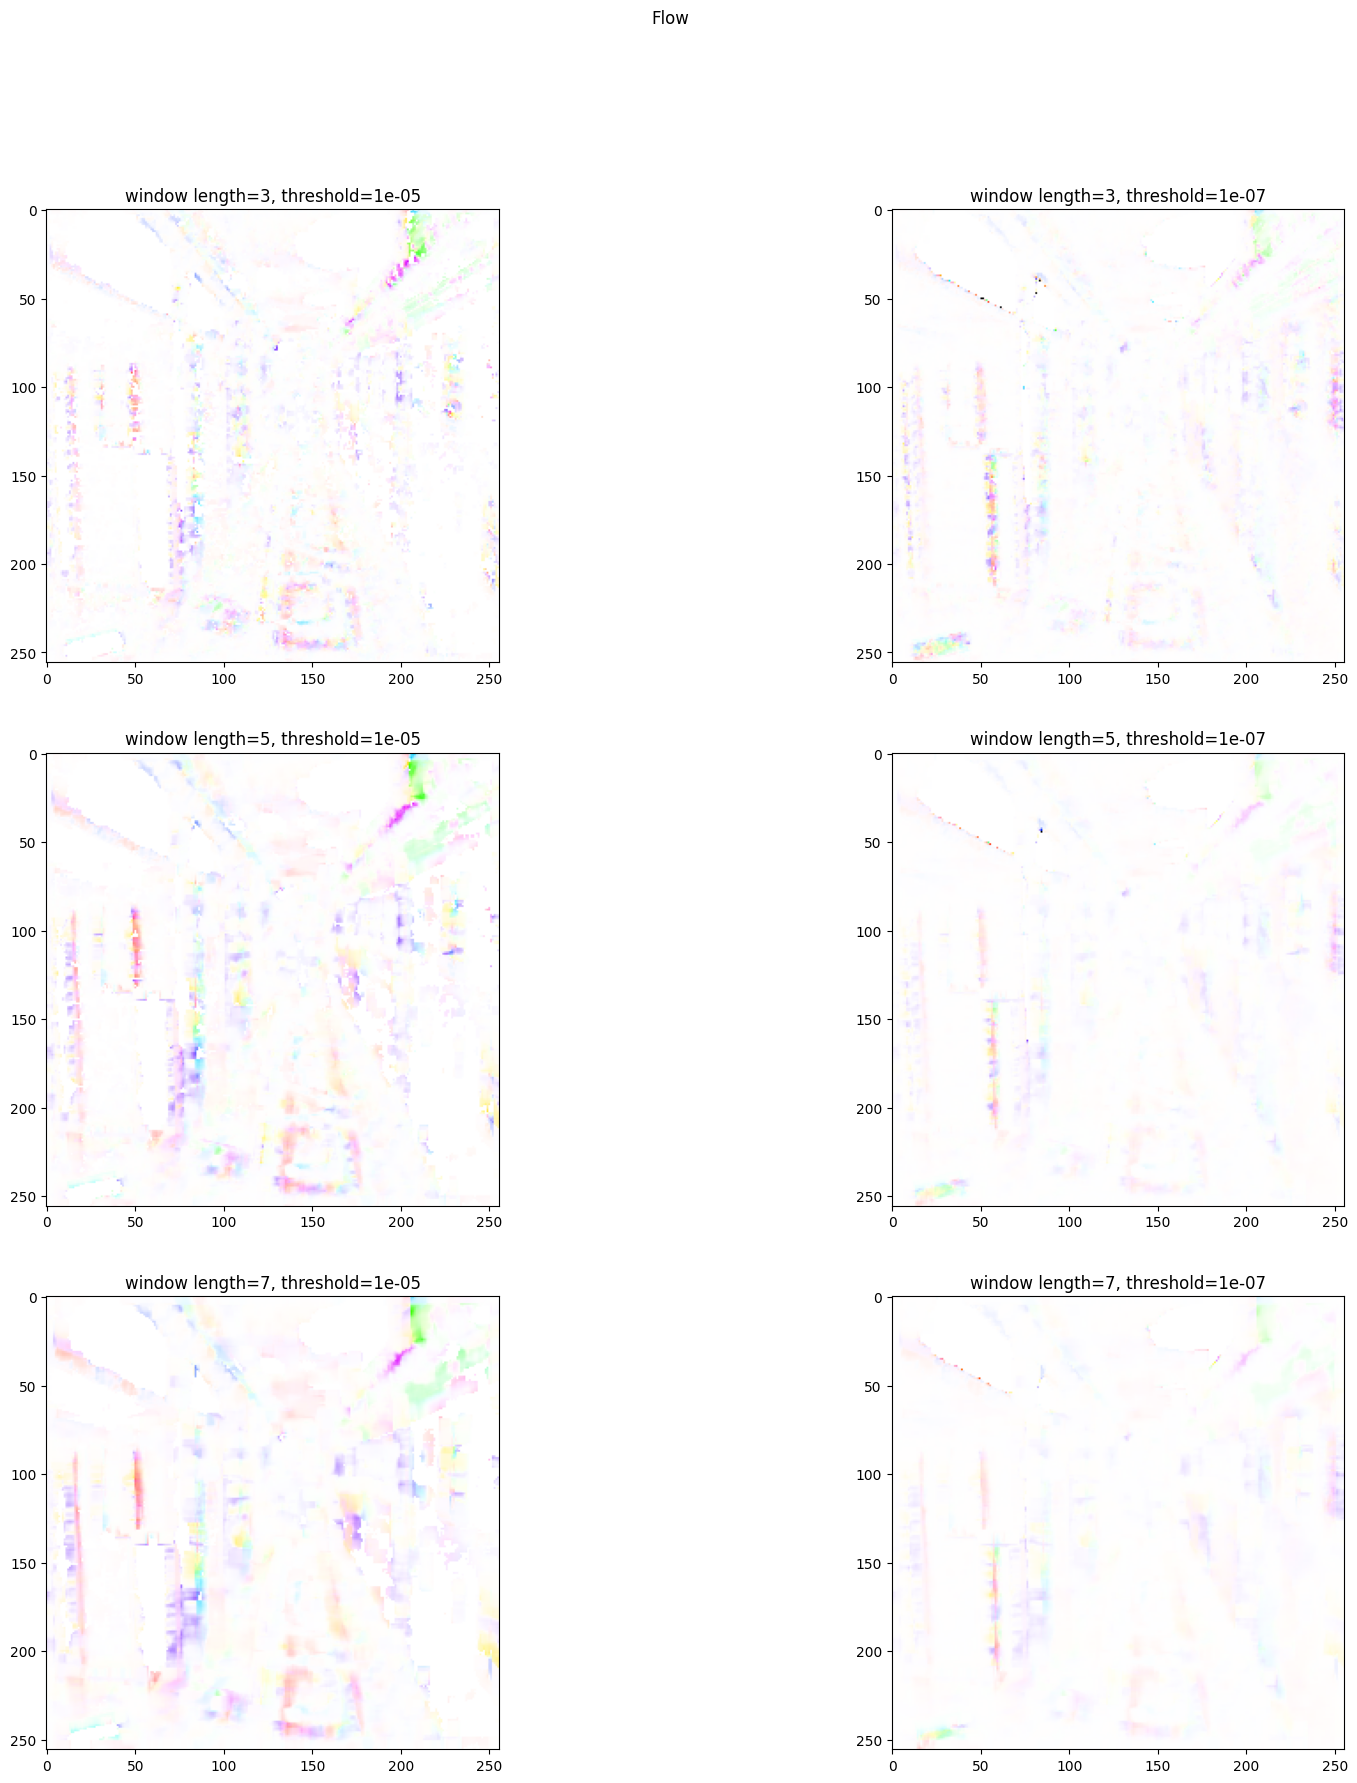

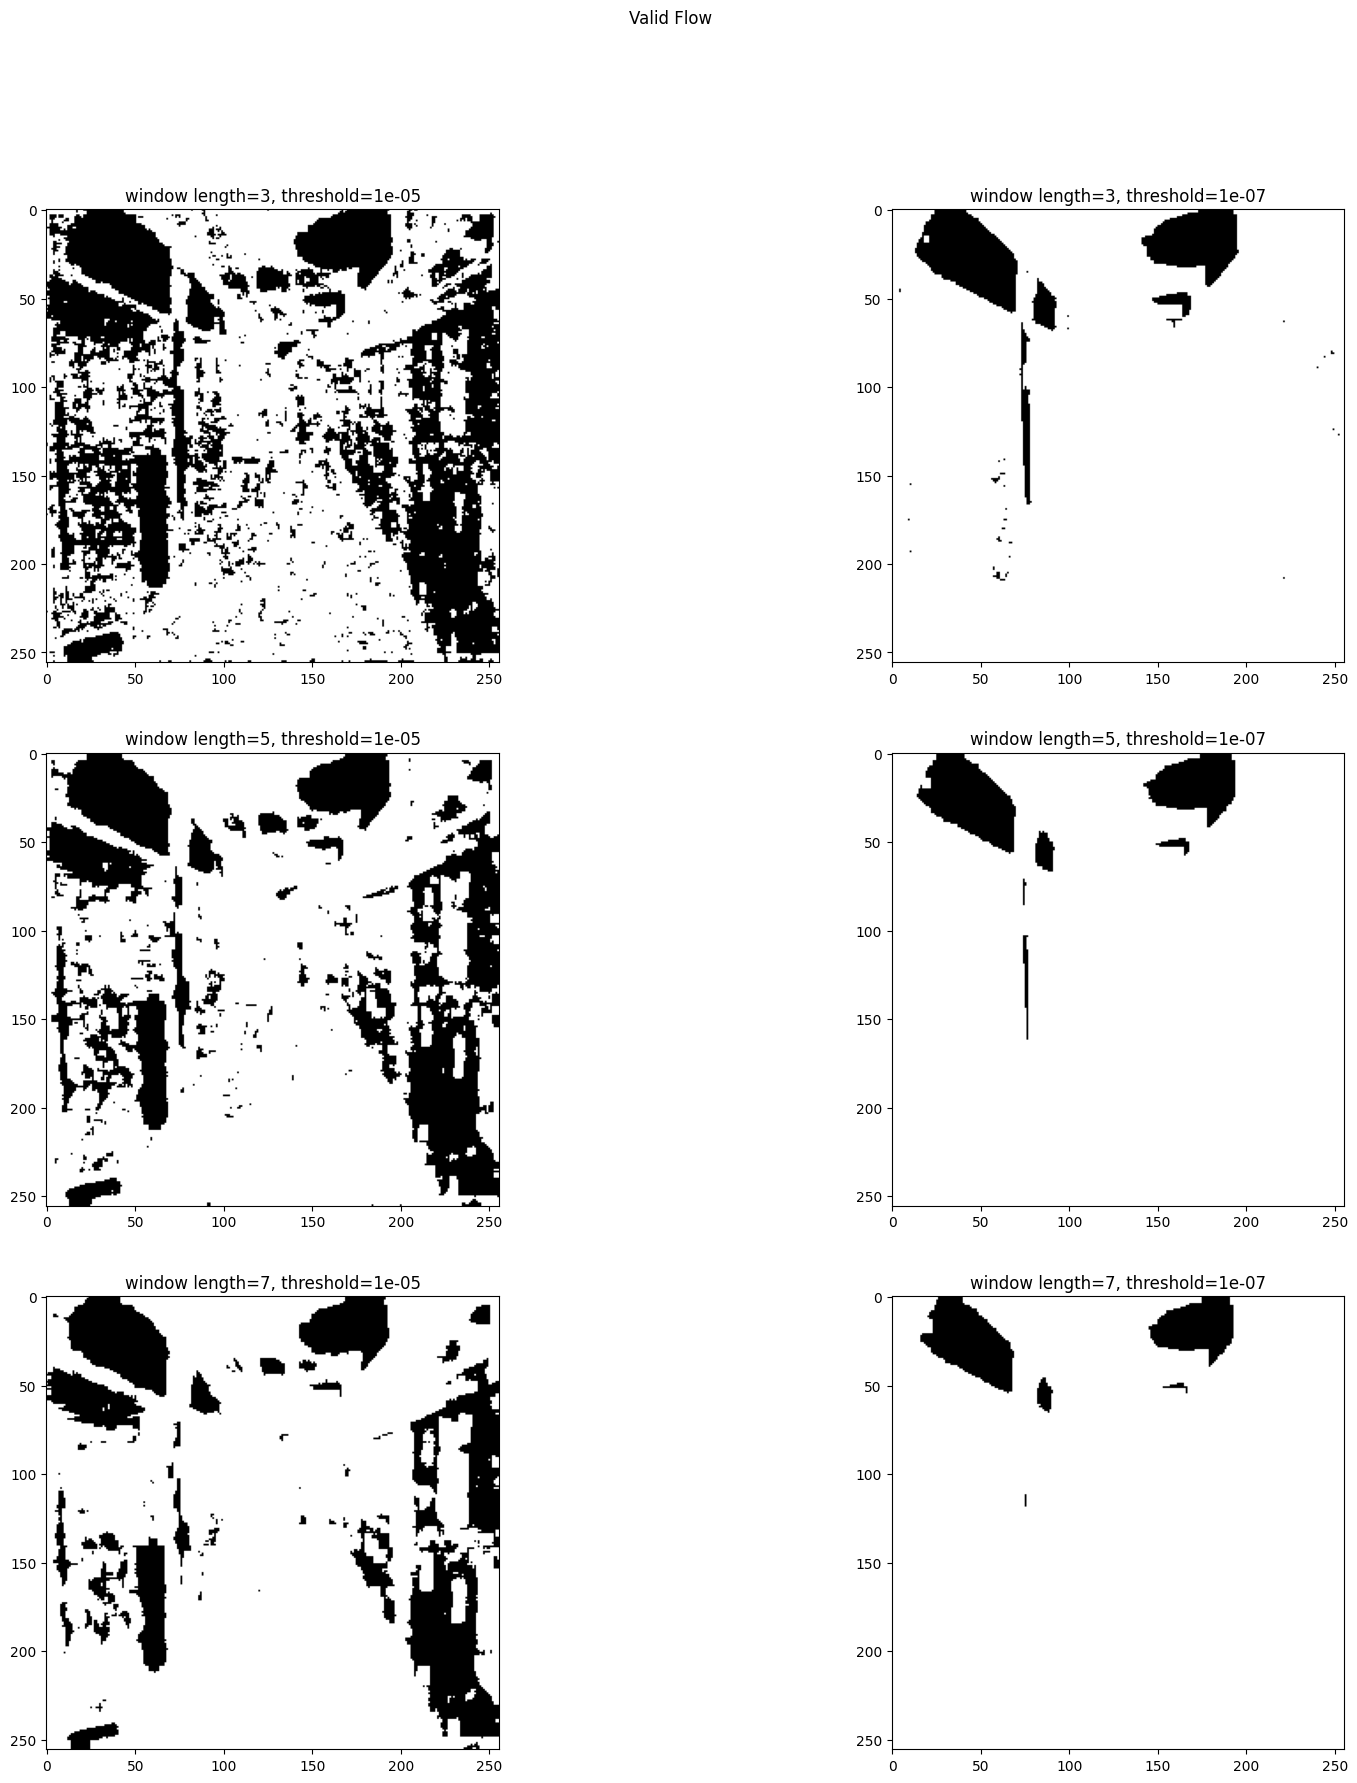

In [11]:
ans_helper(image_corridor1, image_corridor2, window_size_list=[3, 5, 7], tau_list=[1e-5, 1e-7])

## 2

### i) 
**In this part I plot the error map for different parameters. The best ones are chosen for then next part**
**Note that I tested both cubic and linear method, however, cubic didn't improve the results and took much longer to run so I used linear for all parts**

In [12]:
def myWarp(img2_, u_, v_, scale_, method='cubic'):
    
    h, w = img2_.shape
    # Create the xx and yy grid
    grid_x, grid_y = np.meshgrid(np.arange(w, dtype=np.float64), np.arange(h, dtype=np.float64), indexing='xy')
    # Warp the grid
    # Clip the warped results so that they fall into the valid area
    grid_x_warped = grid_x + scale_ * u_
    grid_x_warped = np.clip(grid_x_warped, 0, w-1)
    grid_y_warped = grid_y + scale_ * v_
    grid_y_warped = np.clip(grid_y_warped, 0, h-1)
    # Interpolate the second image. Note that I used RegularGridInterpolator instead of interp2d as it was deprecated.
    interp = RegularGridInterpolator((np.arange(w, dtype=np.float64), np.arange(h, dtype=np.float64)), img2_.T, method=method)
    
    output = np.zeros_like(img2_)
    
    for i in range(h):
        for j in range(w):
            # get the interpolated values
            x_ = grid_x_warped[i, j]
            y_ = grid_y_warped[i, j]
            output[i, j] = interp((x_, y_))
    
    output = np.clip(output, 0, 1)
    return output

In [13]:
def ans_helper2(image1_, image2_, window_size_list=None, tau_list=None):
    
    if tau_list is None:
        tau_list = [1e-4, 1e-5, 1e-7]
    if window_size_list is None:
        window_size_list = [7, 15, 19]
        
    fig_, ax_ = plt.subplots(len(window_size_list), len(tau_list), figsize=(20, 20))
    
    for i, w in enumerate(window_size_list):
        for j, tau in enumerate(tau_list):
            u_, v_, valid_flow_ = myFlow(image1_, image2_, w, tau)
            img2_warped = myWarp(image2_, u_, v_, 1.4, 'linear')
            abs_error = np.abs(img2_warped - image1_)
            ax_[i, j].imshow(abs_error)
            ax_[i, j].set_title(f"window length={w}, threshold={tau}")
    fig_.suptitle("Absolute Error")
    plt.show()

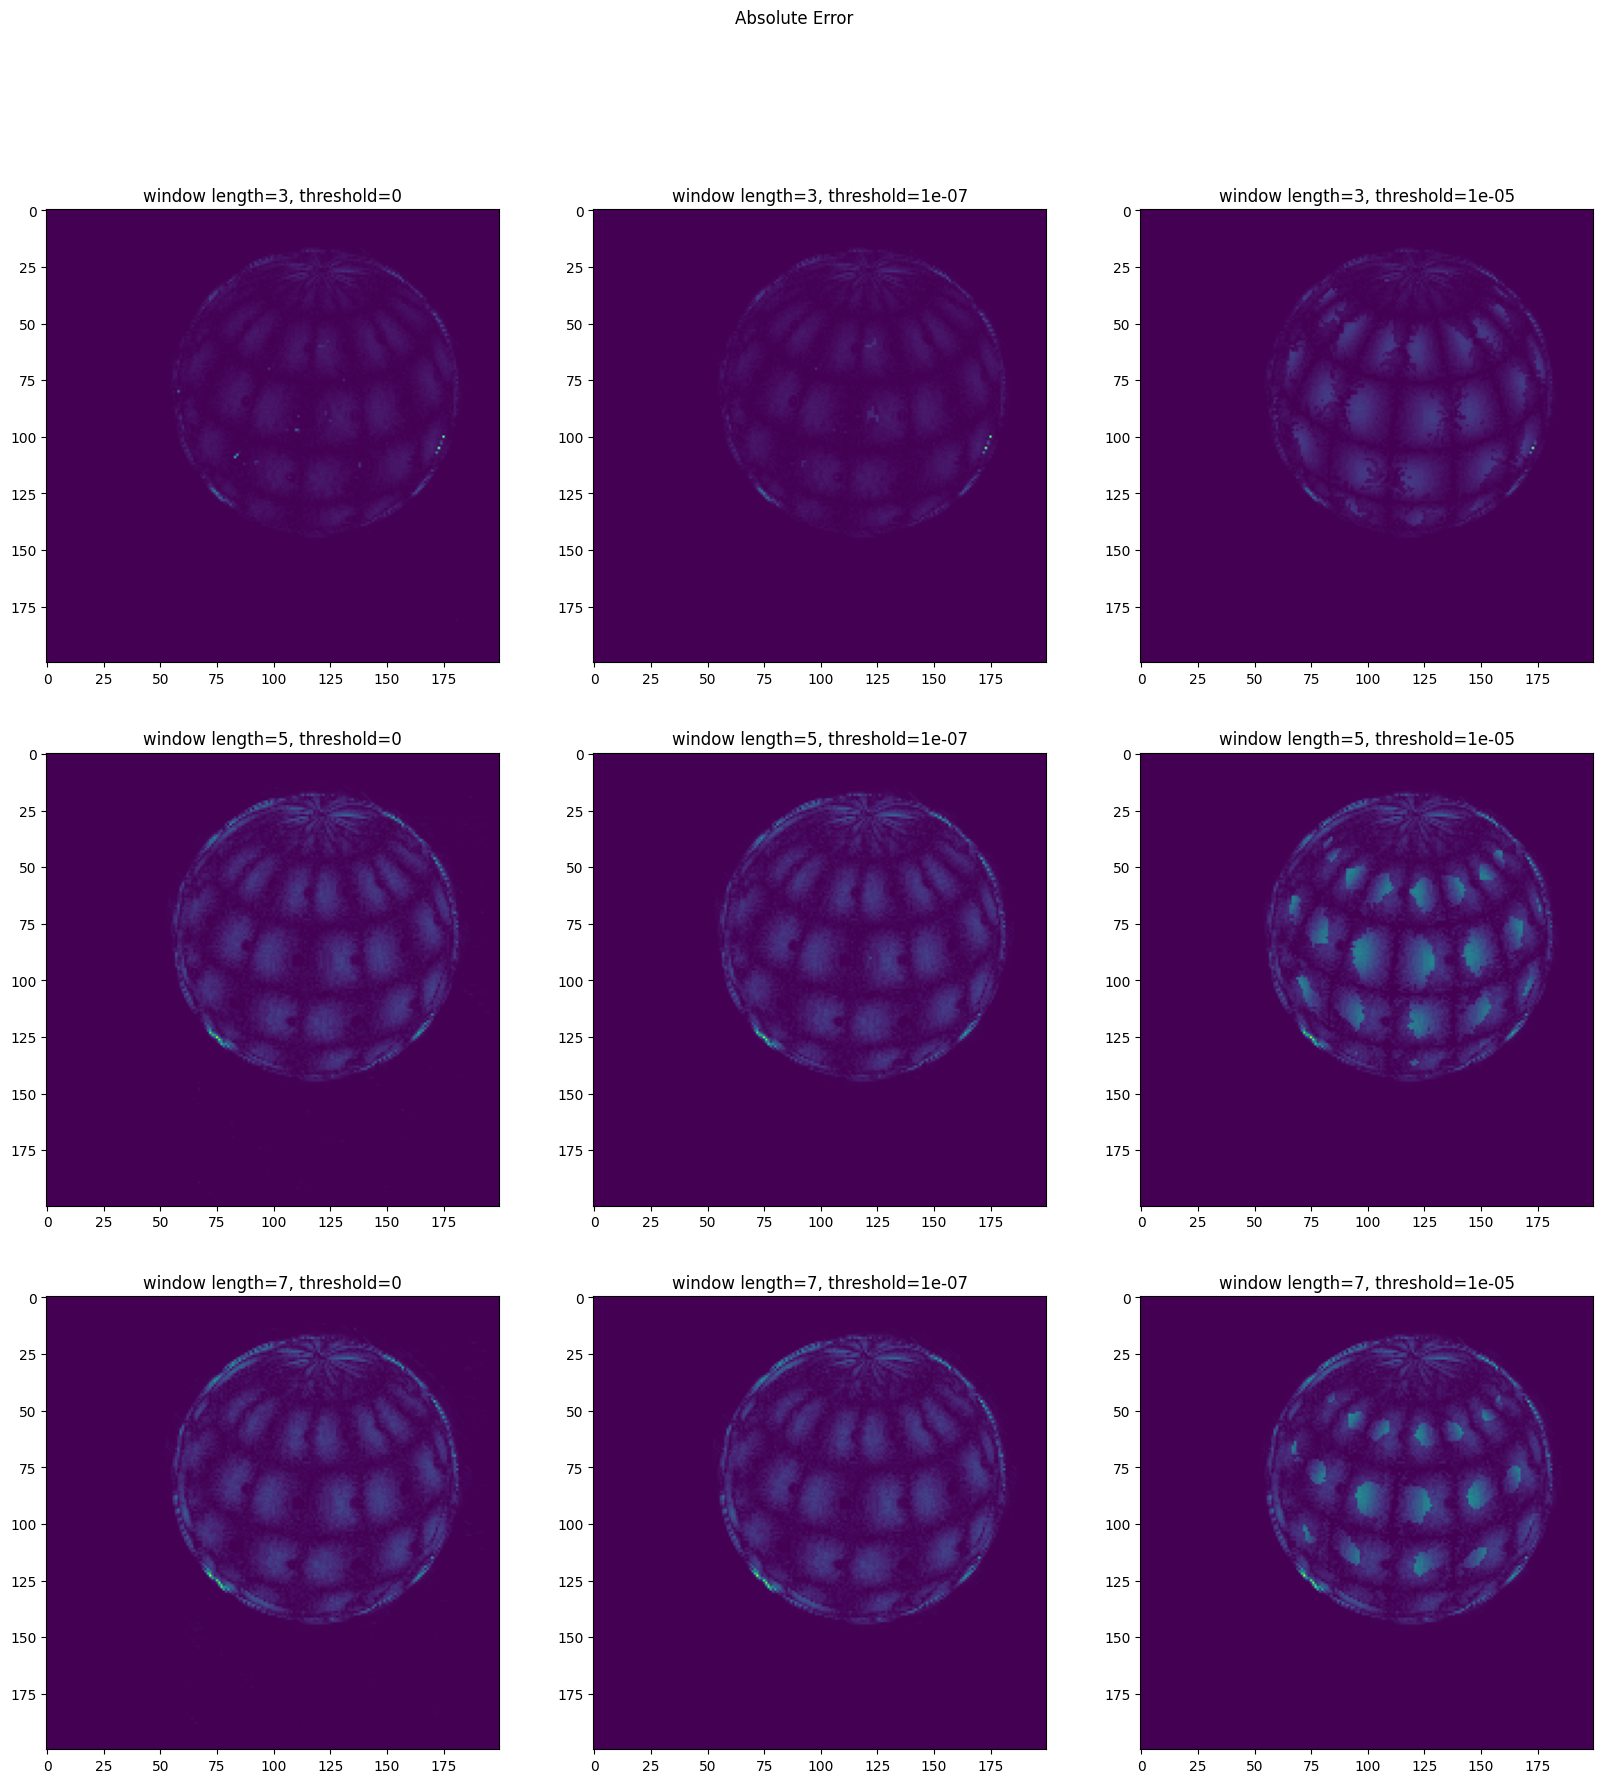

In [14]:
ans_helper2(image_sphere1, image_sphere2, window_size_list=[3, 5, 7], tau_list=[0, 1e-7, 1e-5])

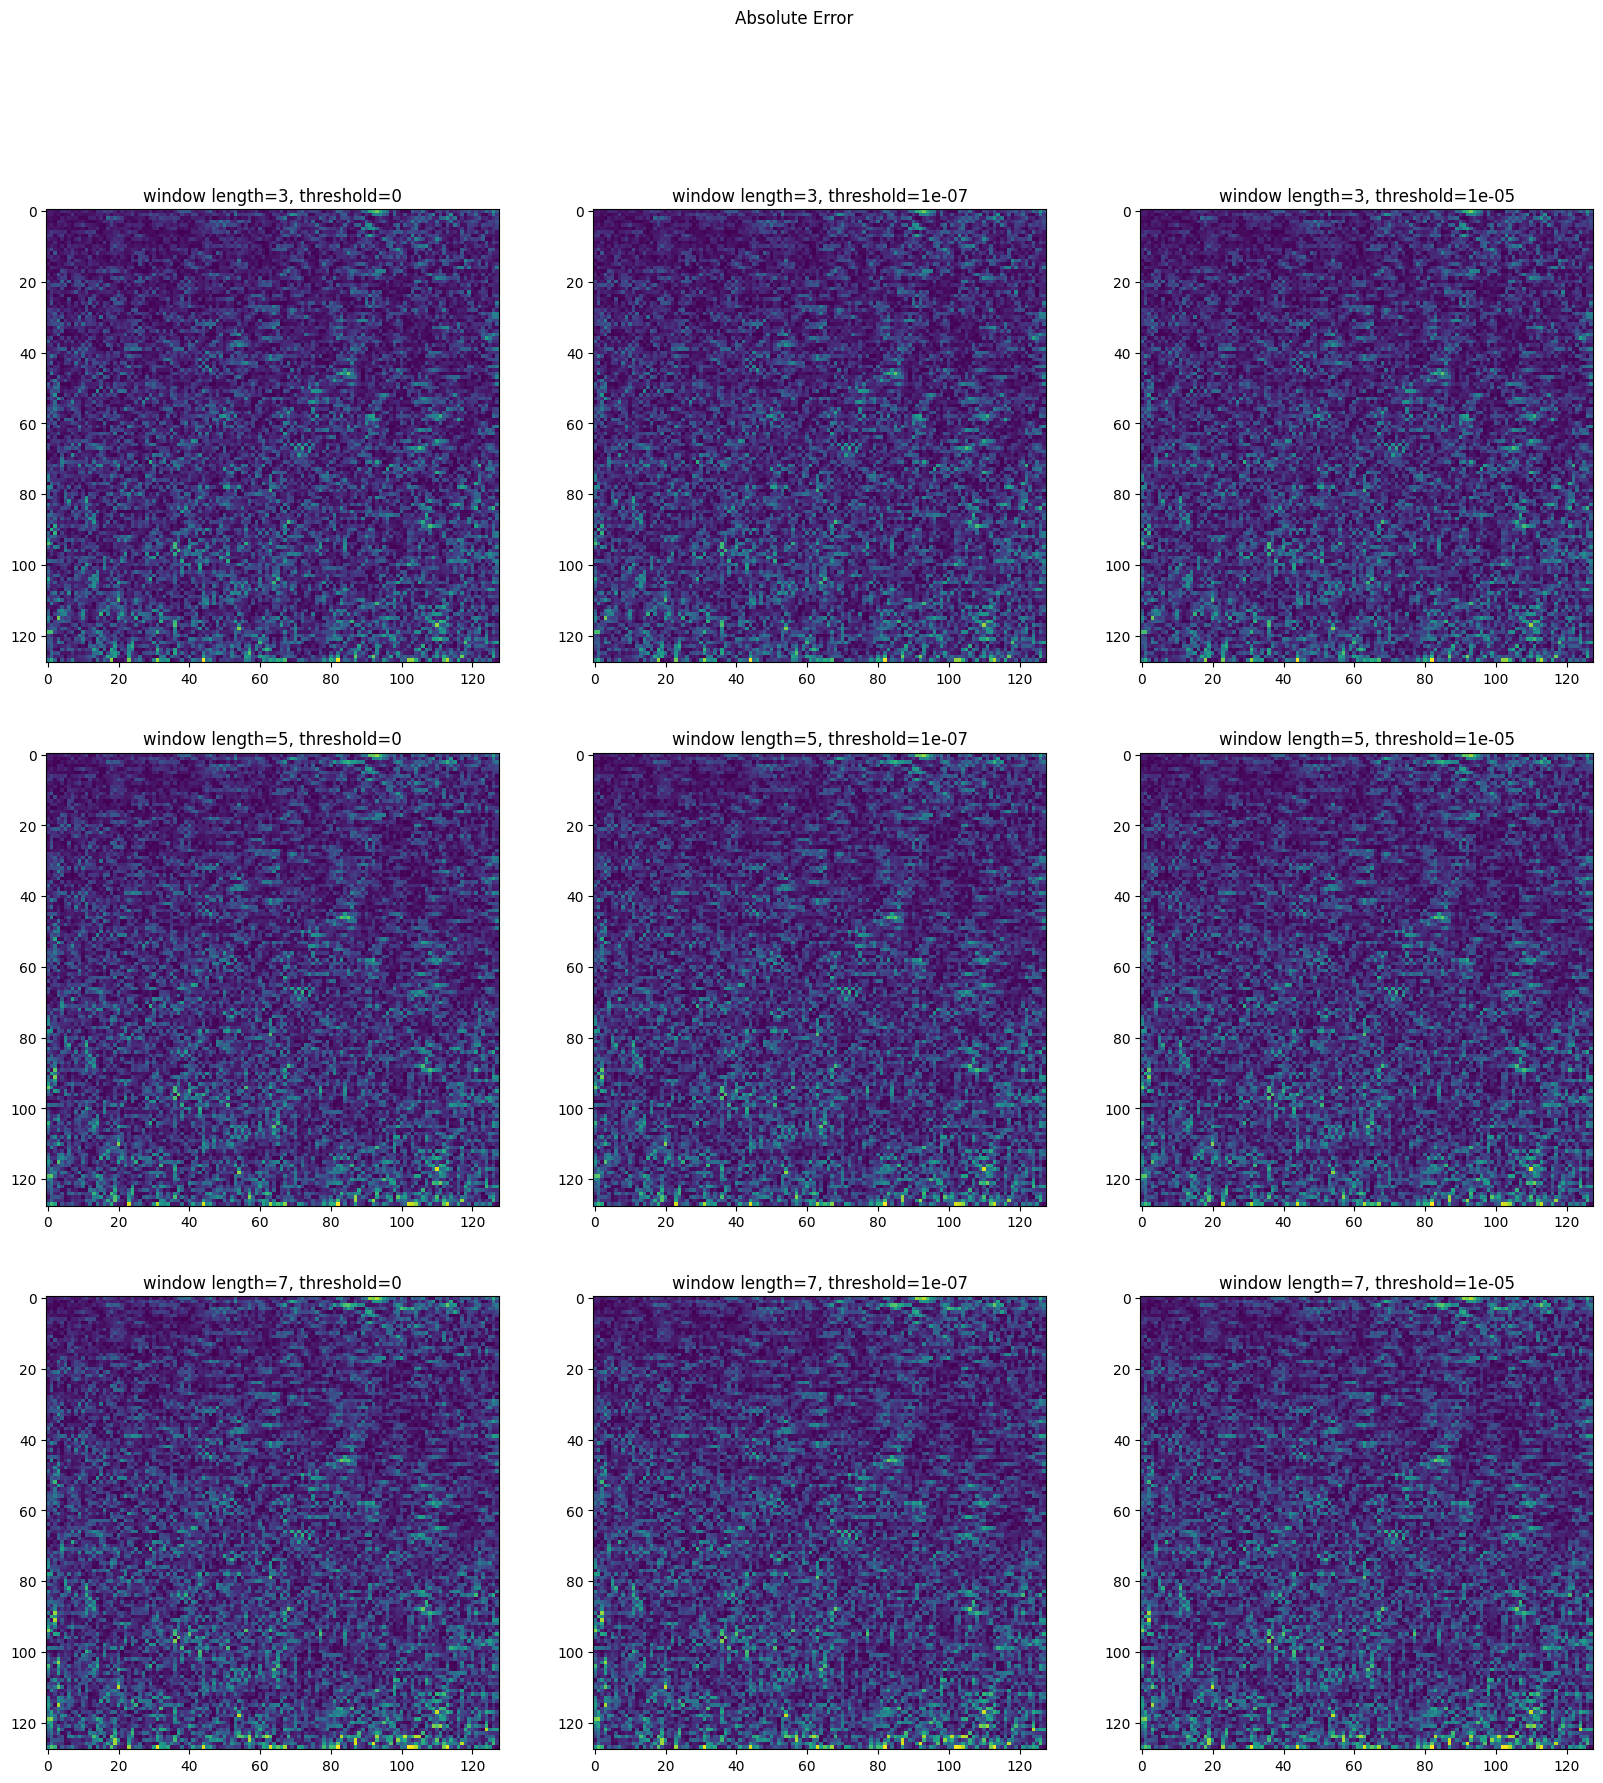

In [15]:
ans_helper2(image_synth1, image_synth2, window_size_list=[3, 5, 7], tau_list=[0, 1e-7, 1e-5])

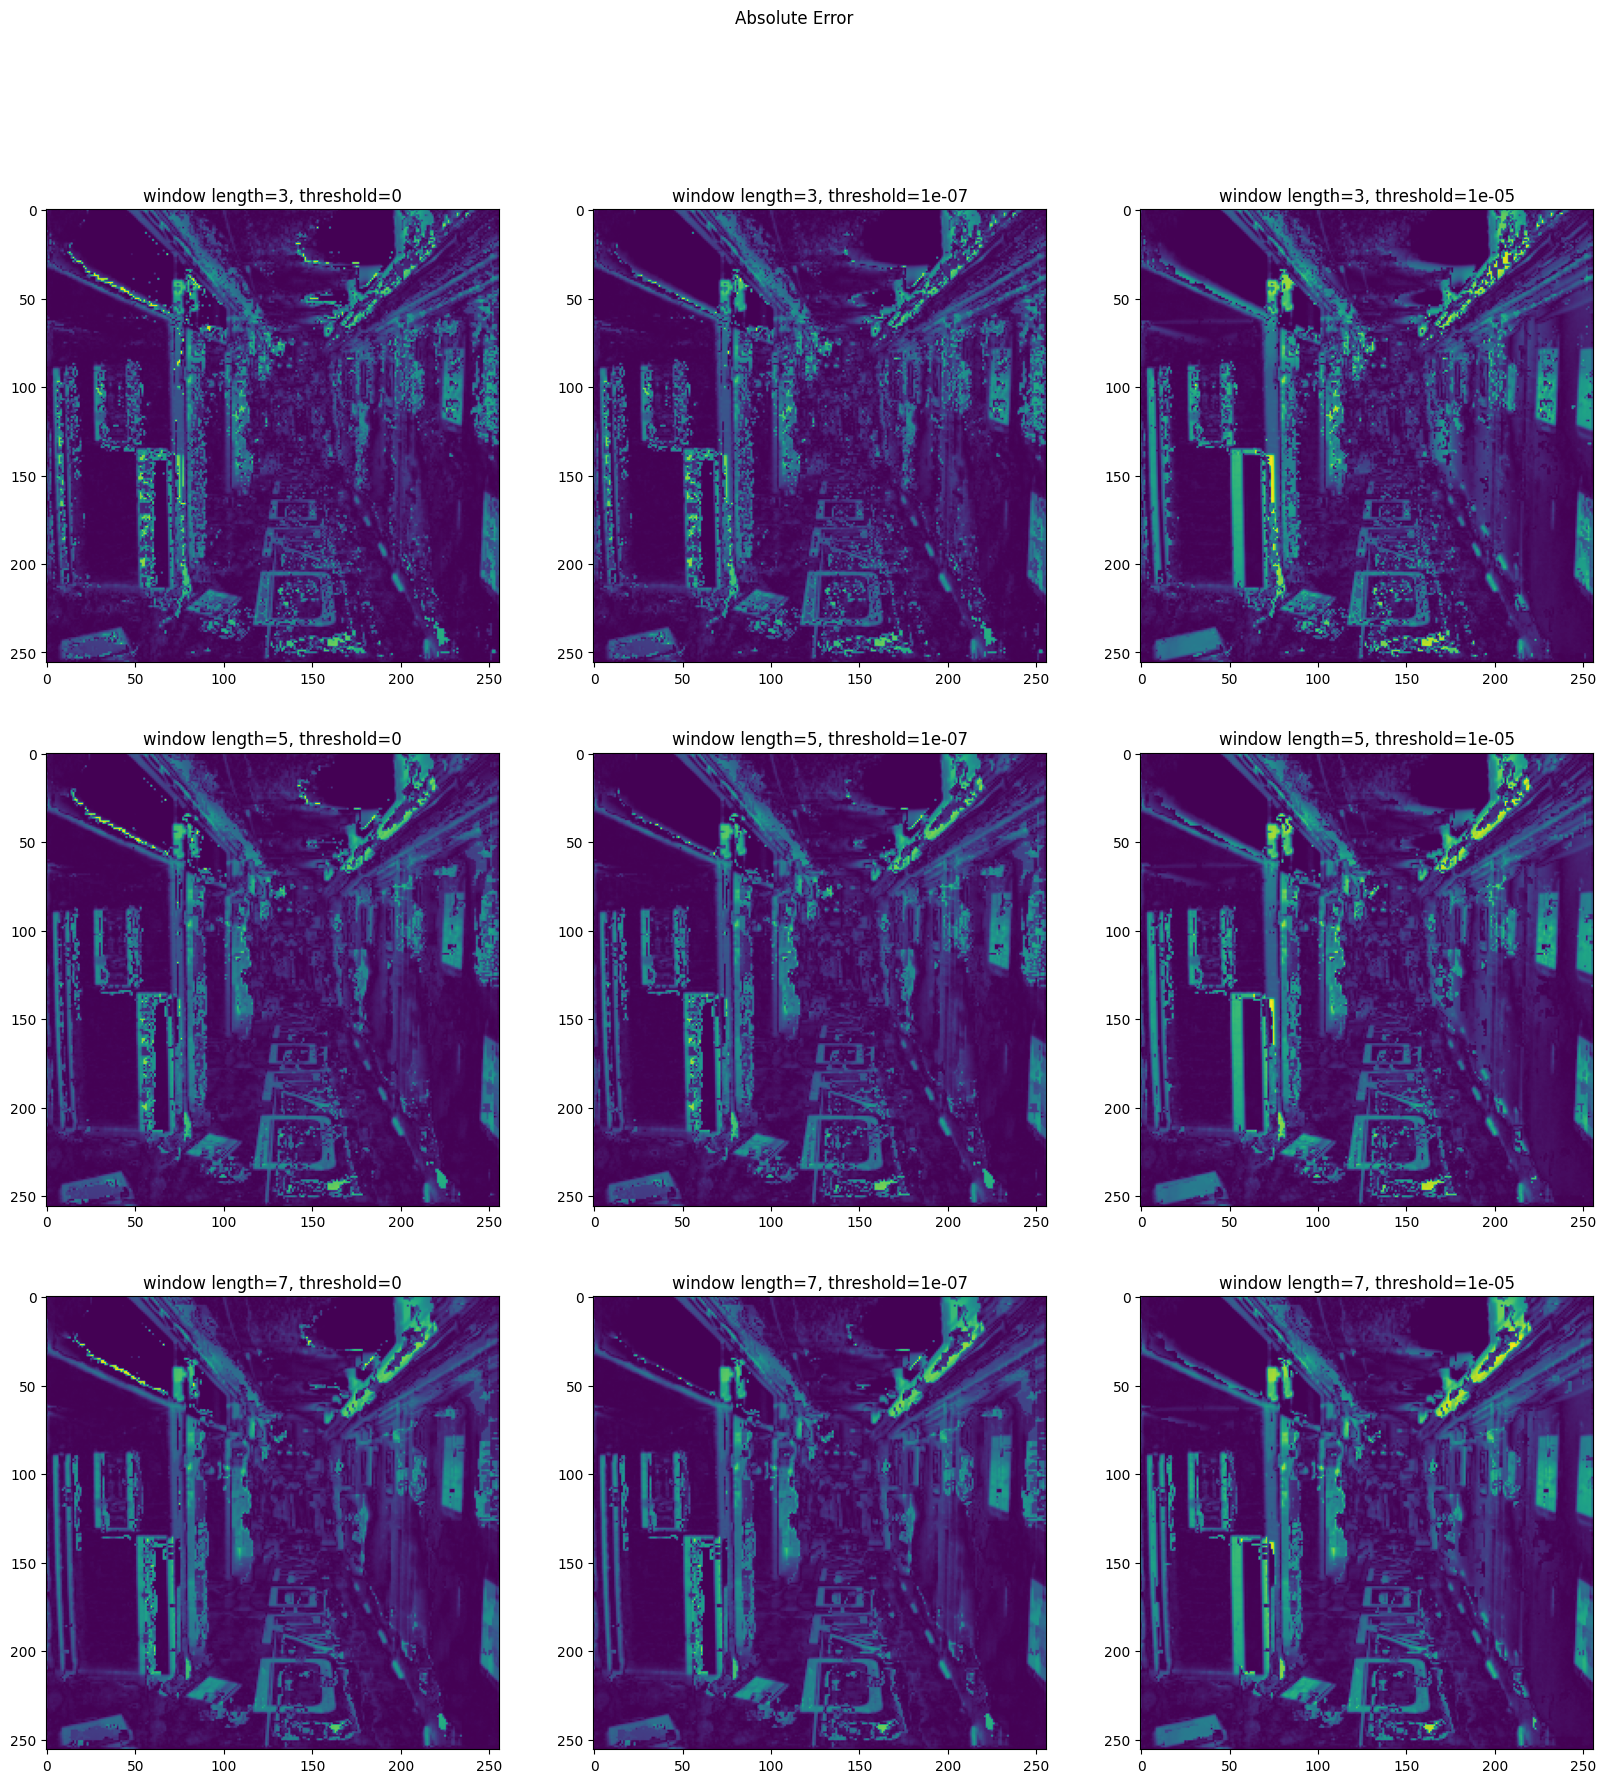

In [16]:
ans_helper2(image_corridor1, image_corridor2, window_size_list=[3, 5, 7], tau_list=[0, 1e-7, 1e-5])

### ii) The result for this part are saved in GIF format and can be found in the submission directory. Open with a browser. For each result the left side is a loop between the first and second image. The right side is a loop between the first image and the warped second image.

In [56]:
def animate_helper(image1_, image2_, window_length_, tau_, f_name, scale_=1):
    u_, v_, valid_flow_ = myFlow(image1_, image2_, window_length_, tau_)
    img2_warped = myWarp(image2_, u_, v_, scale_, 'linear')
    large_1 = np.concatenate((image1_, image1_), axis=1)
    large_2 = np.concatenate((image2_, img2_warped), axis=1)
    images = [PIL.Image.fromarray(np.uint8(large_1 * 255)), PIL.Image.fromarray(np.uint8(large_2 * 255))]
    images *= 50
    images[0].save(f_name, format="GIF", append_images=images, save_all=True, duration=200, loop=0)

In [57]:
animate_helper(image_sphere1, image_sphere2, 3, 0, "sphere.gif", 1)

In [58]:
animate_helper(image_synth1, image_synth2, 3, 0, "synth.gif", 1.5)

In [59]:
animate_helper(image_corridor1, image_corridor2, 3, 1e-5, "corridor.gif", 1)

### Gaussian Pyramid. As we can see, the results for corridor image are not good. Thus, we use Gaussian pyramid.

In [21]:
def pyramid_flow(image1_, image2_, window_length_=15, tau_=0, n_pyramid=4):
    
    pyramid1 = [image1_]
    pyramid2 = [image2_]
    
    for i in range(1, n_pyramid):
        
        smooth1 = scipy.ndimage.gaussian_filter(pyramid1[i-1], sigma=1, truncate=3)
        smooth2 = scipy.ndimage.gaussian_filter(pyramid2[i-1], sigma=1, truncate=3)
        
        down_sampled1 = cv2.resize(smooth1, (0, 0), fx=0.5, fy=0.5)
        down_sampled2 = cv2.resize(smooth2, (0, 0), fx=0.5, fy=0.5)
        
        pyramid1.append(down_sampled1)
        pyramid2.append(down_sampled2)
        
    u_, v_, _ = myFlow(pyramid1[n_pyramid-1], pyramid2[n_pyramid-1], window_length_, tau_)
    
    for i in range(n_pyramid-2, -1, -1):
        u_ = 2 * cv2.resize(u_, (0, 0), fx=2, fy=2)
        v_ = 2 * cv2.resize(v_, (0, 0), fx=2, fy=2)
        
        img2_warped = myWarp(pyramid2[i], u_, v_, 1, 'cubic')
        du_, dv_, _ = myFlow(pyramid1[i], img2_warped, window_length_, tau_)
        
        u_ = u_ + du_
        v_ = v_ + dv_

    img2_warped = myWarp(pyramid2[0], u_, v_, 1, 'cubic')
    
    return img2_warped

In [52]:
def animate_helper_pyramid(image1_, image2_, window_length_, tau_, f_name, n_p):
    img2_warped = pyramid_flow(image1_, image2_, window_length_, tau_, n_p)
    large_1 = np.concatenate((image1_, image1_), axis=1)
    large_2 = np.concatenate((image2_, img2_warped), axis=1)
    images = [PIL.Image.fromarray(np.uint8(large_1 * 255)), PIL.Image.fromarray(np.uint8(large_2 * 255))]
    images *= 50
    images[0].save(f_name, format="GIF", append_images=images, save_all=True, duration=200, loop=0)

In [53]:
animate_helper_pyramid(image_corridor1, image_corridor2, 15, 0, "corridor_pyramid.gif", 4)

In [54]:
animate_helper_pyramid(image_sphere1, image_sphere2, 3, 1e-5, "sphere_pyramid.gif", 3)

In [55]:
animate_helper_pyramid(image_synth1, image_synth2, 3, 0, "synth_pyramid.gif", 3)

## 3
**The please refer to hotel_out.gif for the first output of this part. The second output is at the end of this part. Note that since the key points are selected randomly, the output changes after each run**

### Harris Corner Detector

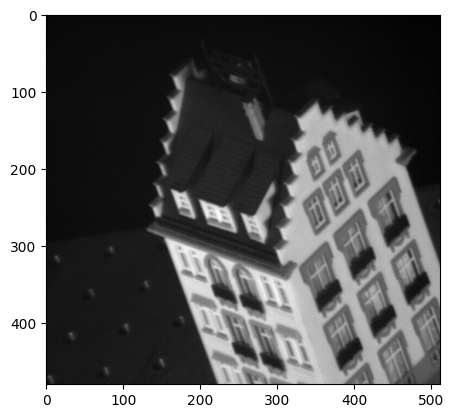

In [26]:
img0 = cv2.imread('Hotel Sequence/hotel.seq0.png')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.
plt.imshow(img0, 'gray')
plt.show()

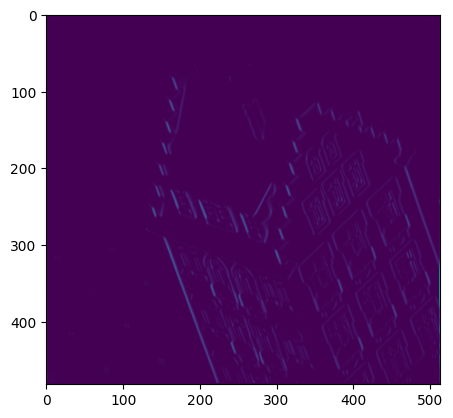

In [27]:
x_derivative_kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])
Ix = convolve2d(img0, x_derivative_kernel)
plt.imshow(Ix ** 2)
plt.show()

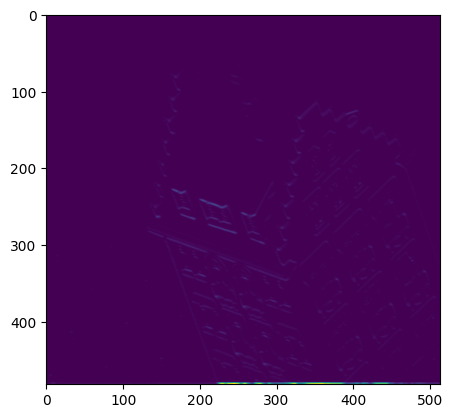

In [28]:
Iy = convolve2d(img0, x_derivative_kernel.T)
plt.imshow(Iy ** 2)
plt.show()

In [29]:
Ix2 = scipy.ndimage.gaussian_filter(Ix ** 2, sigma=5, truncate=3)
Iy2 = scipy.ndimage.gaussian_filter(Iy ** 2, sigma=5, truncate=3)
Ixy = scipy.ndimage.gaussian_filter(Iy * Ix, sigma=5, truncate=3)

In [30]:
k = 0.04
r = (Ix2 * Iy2 - Ixy ** 2) - k * (Ix2 + Iy2) ** 2

In [31]:
local_max = peak_local_max(r, min_distance=20, threshold_rel=0.007)

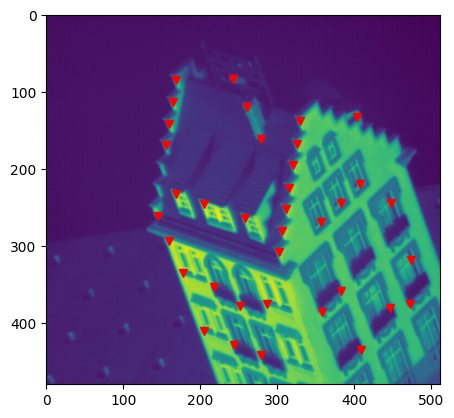

In [32]:
for pt in local_max:
    plt.plot(pt[1], pt[0], 'r', marker='v')
plt.imshow(img0)
plt.show()

In [33]:
def myHarris(image_, n_pts=20, min_distance=15, threshold_abs=1e-4):
    
    x_derivative_kernel_ = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
    ])
    
    Ix_ = convolve2d(image_, x_derivative_kernel_)
    Iy_ = convolve2d(img0, x_derivative_kernel_.T)

    Ix2_ = scipy.ndimage.gaussian_filter(Ix_ ** 2, sigma=5, truncate=3)
    Iy2_ = scipy.ndimage.gaussian_filter(Iy_ ** 2, sigma=5, truncate=3)
    Ixy_ = scipy.ndimage.gaussian_filter(Iy_ * Ix_, sigma=5, truncate=3)
    
    k_ = 0.04
    r_ = (Ix2_ * Iy2_ - Ixy_ ** 2) - k_ * (Ix2_ + Iy2_) ** 2
    local_max_ = peak_local_max(r_, min_distance=min_distance, threshold_abs=threshold_abs)
    
    if n_pts < len(local_max_):
        idx = np.arange(len(local_max_))
        np.random.shuffle(idx)
        idx = idx[:n_pts]
        local_max_ = local_max_[idx, :]
    
    return local_max_

In [34]:
# the second argument determines the number of random points to be tracked
local_max = myHarris(img0, 20)

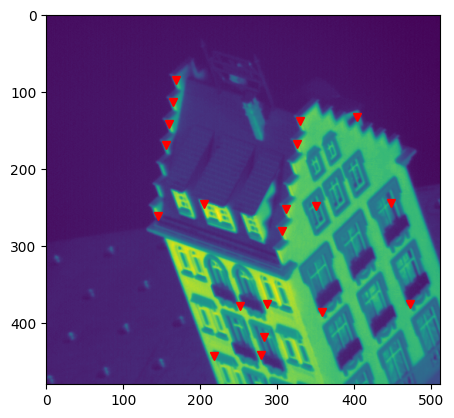

In [35]:
for pt in local_max:
    plt.plot(pt[1], pt[0], 'r', marker='v')
plt.imshow(img0)
plt.show()

In [36]:
# Just like myFlow function, however, here flow is only computed for given points
def mySparseFlow(image1_, image2_, window_length, tau, points):
    # Spatial Derivative Filter
    derivative_kernel = np.array([[-1, 8, 0, -8, 1]], dtype=np.float64) / 12
    # convolve2d flips the kernel, so there is no need to flip it
    # Computing the Spatial Derivatives
    x_derivative = convolve2d(image1_, derivative_kernel, 'same')
    y_derivative = convolve2d(image1_, derivative_kernel.T, 'same')
    # Smooth the Images for Temporal Derivative
    smooth_image1 = scipy.ndimage.gaussian_filter(image1_, 1.0, truncate=3)
    smooth_image2 = scipy.ndimage.gaussian_filter(image2_, 1.0, truncate=3)
    # Temporal Derivative
    t_derivative = smooth_image2 - smooth_image1
    # Computing the Sum of Derivative Products
    Ixt = scipy.ndimage.uniform_filter(x_derivative * t_derivative, size=window_length)
    Iyt = scipy.ndimage.uniform_filter(y_derivative * t_derivative, size=window_length)
    Ixx = scipy.ndimage.uniform_filter(x_derivative * x_derivative, size=window_length)
    Iyy = scipy.ndimage.uniform_filter(y_derivative * y_derivative, size=window_length)
    Ixy = scipy.ndimage.uniform_filter(x_derivative * y_derivative, size=window_length)
    # Interpolate the above variables since points are not necessarily integers
    h_, w_ = image1_.shape
    Ixt = RegularGridInterpolator((np.arange(w_, dtype=np.float64), np.arange(h_, dtype=np.float64)), Ixt.T)
    Iyt = RegularGridInterpolator((np.arange(w_, dtype=np.float64), np.arange(h_, dtype=np.float64)), Iyt.T)
    Ixx = RegularGridInterpolator((np.arange(w_, dtype=np.float64), np.arange(h_, dtype=np.float64)), Ixx.T)
    Iyy = RegularGridInterpolator((np.arange(w_, dtype=np.float64), np.arange(h_, dtype=np.float64)), Iyy.T)
    Ixy = RegularGridInterpolator((np.arange(w_, dtype=np.float64), np.arange(h_, dtype=np.float64)), Ixy.T)
    
    # u_: flow in x direction
    # v_: flow in y direction
    u_ = []
    v_ = []
        
    for pt in points:
            # For each pt compute the flow
            i, j = pt[0], pt[1]
            
            # Defining the matrix A for each pixel as defined in the assignment document
            A = np.array([[Ixx((i, j)), Ixy((i, j))],
                          [Ixy((i, j)), Iyy((i, j))]])
            # Defining the vector b for each pixel as defined in the assignment document
            b = np.array([[-Ixt((i, j))], [-Iyt((i, j))]])
            # Compute the eigenvalues of A
            l = np.linalg.eigvals(A).real
            # Check the validity of flow by comparing eigenvalues with the threshold tau
            if l[0] > tau and l[1] > tau:
                # pseudo inverse A and multiply by b
                uv = np.linalg.pinv(A) @ b
                # separate the flow
                uv = uv.flatten()
                u_.append(uv[0])
                v_.append(uv[1])
    
    return u_, v_

In [37]:
img0 = cv2.imread('Hotel Sequence/hotel.seq0.png')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.

In [45]:
# number of frames in the sequence
n_frames = len(os.listdir("Hotel Sequence"))
# initial frame
prev_frame = img0
# Choose 20 key points to track
key_points = myHarris(img0, 20).astype(np.float64)
# myHarris returns (y,x) so I convert it to (x,y)
key_points = key_points[:, ::-1]
# save the initial points (not necessary!)
key_points_init = key_points.copy()
# save all frames
frames = [prev_frame]
# trajectory is a list of tuples (key_points_t, key_points_t+1)
trajectory = []
# index of points that stay in the valid area until the last frame
valid_idx = np.arange(len(key_points))
valid_indices = []

for i in range(n_frames-1):
    # Read the next frame and append it to frames
    next_frame = cv2.imread('Hotel Sequence/hotel.seq' + str(i+1) + '.png')
    next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.
    frames.append(next_frame)
    # Compute the flow for key_points
    u, v = mySparseFlow(prev_frame, next_frame, 15, 0, key_points)
    u = np.array(u).reshape((-1, 1))
    v = np.array(v).reshape((-1, 1))
    flow = np.concatenate((u, v), axis=1)
    # Move the key_points along their respective flow vector
    key_points_next = key_points + flow
    # Find the valid key_points. Note that I consider points closer than 6 pixels to boundaries of the image to be invalid
    validity_check = ((key_points_next[:, 0] > 5) * (key_points_next[:, 1] > 5) * (key_points_next[:, 0] < img0.shape[0] - 5) *
                      (key_points_next[:, 1] < img0.shape[1] - 5))
    # Discard invalid key_points
    key_points = key_points[validity_check, :]
    key_points_next = key_points_next[validity_check, :]
    valid_idx = valid_idx[validity_check]
    valid_indices.append(valid_idx)
    # Add the key points in previous and next frame to the trajectory
    trajectory.append(np.concatenate((key_points, key_points_next), axis=1))
    # Update previous frame and key points
    key_points = key_points_next
    prev_frame = next_frame

In [46]:
if not os.path.exists("out_sequence"):
    os.mkdir("out_sequence")

In [47]:
for i in range(n_frames):
    plt.figure()
    if i == 0:
        # plot initial points on the first frame
        for pt in key_points_init:
            plt.plot(pt[0], pt[1], 'r', marker='o')
    else:
        # for each frame plot the trajectory up until then.
        for j, segment in enumerate(trajectory):
            if j < i:
                for pts in segment:
                    plt.plot([pts[0], pts[2]], [pts[1], pts[3]], 'b') 
        # for each frame plot the estimated location of key points
        for pts in trajectory[i-1]:
            plt.plot(pts[2], pts[3], 'r', marker='o')

    plt.imshow(frames[i], 'gray')
    # save the result
    plt.savefig("out_sequence/out" + str(i) + ".png")
    plt.close()

In [48]:
images_out = []
# combine the results into a gif
for i in range(n_frames):
    images_out.append(PIL.Image.open("out_sequence/out" + str(i) + ".png"))
images_out[0].save('hotel_out.gif', format="GIF", append_images=images_out, save_all=True, duration=200, loop=0)

In [49]:
valid_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

As we can see, all points remain valid, so I cannot plot points that are invalid! To be able to do so, I select more points with the hope that at least one of them becomes invalid

In [50]:
# number of frames in the sequence
n_frames = len(os.listdir("Hotel Sequence"))
# initial frame
prev_frame = img0
# Choose 20 key points to track
key_points = myHarris(img0, 100, min_distance=5, threshold_abs=1e-4).astype(np.float64)
# myHarris returns (y,x) so I convert it to (x,y)
key_points = key_points[:, ::-1]
# save the initial points (not necessary!)
key_points_init = key_points.copy()
# save all frames
frames = [prev_frame]
# trajectory is a list of tuples (key_points_t, key_points_t+1)
trajectory = []
# index of points that stay in the valid area until the last frame
valid_idx = np.arange(len(key_points))
valid_indices = []
# all locations
all_locs = []

for i in range(n_frames-1):
    # Read the next frame and append it to frames
    next_frame = cv2.imread('Hotel Sequence/hotel.seq' + str(i+1) + '.png')
    next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.
    frames.append(next_frame)
    # Compute the flow for key_points
    u, v = mySparseFlow(prev_frame, next_frame, 15, 0, key_points)
    u = np.array(u).reshape((-1, 1))
    v = np.array(v).reshape((-1, 1))
    flow = np.concatenate((u, v), axis=1)
    # Move the key_points along their respective flow vector
    key_points_next = key_points + flow
    all_locs.append(key_points_next)
    # Find the valid key_points. Note that I consider points closer than 6 pixels to boundaries of the image to be invalid
    validity_check = ((key_points_next[:, 0] > 5) * (key_points_next[:, 1] > 5) * (key_points_next[:, 0] < img0.shape[0] - 5) *
                      (key_points_next[:, 1] < img0.shape[1] - 5))
    # Discard invalid key_points
    key_points = key_points[validity_check, :]
    key_points_next = key_points_next[validity_check, :]
    valid_idx = valid_idx[validity_check]
    valid_indices.append(valid_idx)
    # Add the key points in previous and next frame to the trajectory
    trajectory.append(np.concatenate((key_points, key_points_next), axis=1))
    # Update previous frame and key points
    key_points = key_points_next
    prev_frame = next_frame

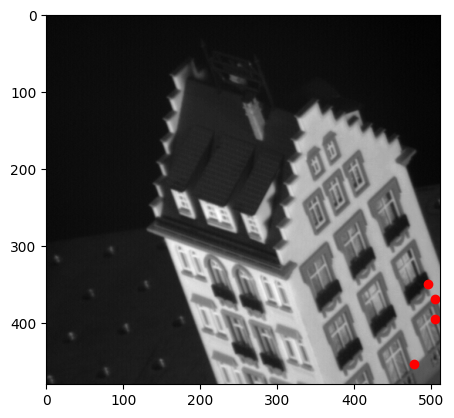

In [51]:
for i, pt in enumerate(key_points_init):
    if i not in valid_idx:
        plt.plot(pt[0], pt[1], 'r', marker='o')
plt.imshow(frames[0], 'gray')
plt.show()